# Results for BERT when applying syn tranformation to both premise and hypothesis

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML 
from lr.analysis.util import get_ts_from_results_folder 
from lr.analysis.util import get_rho_stats_from_result_list
from lr.stats.h_testing import get_ks_stats_from_p_values_compared_to_uniform_dist

## Get Results

In [2]:
all_accs = []
all_transformed_accs = []
all_paired_t_p_values = []
all_dev_plus_diff = []
all_time = []

m_name = "bert_base"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    test_accuracy  = get_ts_from_results_folder(path="results/snli/{}/syn_p_h/batch{}/".format(m_name, i),
                                                 stat="test_accuracy")
    
    transformed_test_accuracy = get_ts_from_results_folder(path="results/snli/{}/syn_p_h/batch{}/".format(m_name, i),
                                                           stat="transformed_test_accuracy")
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/snli/{}/syn_p_h/batch{}/".format(m_name, i),
                                                    stat="paired_t_p_value")
    
    diff  = get_ts_from_results_folder(path="results/snli/{}/syn_p_h/batch{}/".format(m_name, i),
                                                    stat="dev_plus_accuracy_difference")
    
    t_time  = get_ts_from_results_folder(path="results/snli/{}/syn_p_h/batch{}/".format(m_name,i),
                                                    stat="test_time")

    
    all_accs.append(test_accuracy)
    all_transformed_accs.append(transformed_test_accuracy)
    all_paired_t_p_values.append(paired_t_p_value)
    all_dev_plus_diff.append(diff)
    all_time.append(t_time)

100%|██████████| 5/5 [00:00<00:00, 11.09it/s]


In [3]:
total_time = pd.concat(all_time,1).sum().sum()
n_params = 109484547
print("Time for all experiments = {:.1f} hours".format(total_time))
print("Number of paramaters for BERT = {}".format(n_params))

Time for all experiments = 289.2 hours
Number of paramaters for BERT = 109484547


## Accuracy

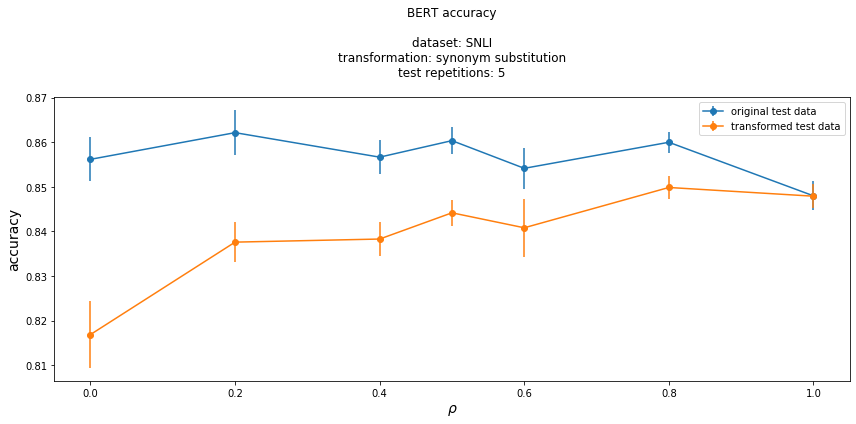

In [4]:
rhos, mean_acc, error_acc, _ = get_rho_stats_from_result_list(all_accs)

_, mean_acc_t, error_acc_t, _ = get_rho_stats_from_result_list(all_transformed_accs)

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(rhos, mean_acc, yerr=error_acc, fmt='-o', label="original test data");
ax.errorbar(rhos, mean_acc_t, yerr=error_acc_t, fmt='-o', label="transformed test data");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("accuracy", fontsize=14);
ax.set_title("BERT accuracy\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
fig.tight_layout()
fig.savefig('figs/bert_base_acc_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## P-values

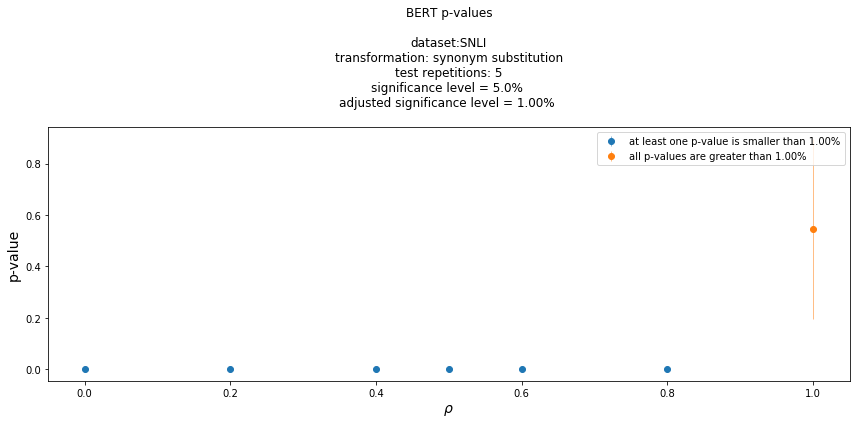

In [5]:
rhos, mean_p_values, error_p_values, min_p_values = get_rho_stats_from_result_list(all_paired_t_p_values)

alpha = 0.05
alpha_adj = alpha / test_repetitions

rejected_ids = []
remain_ids = []

for i,p in enumerate(min_p_values):
    if p < alpha_adj:
        rejected_ids.append(i)
    else:
        remain_ids.append(i)
        
rhos_rejected = rhos[rejected_ids]
rhos_remain = rhos[remain_ids]
y_rejected = mean_p_values[rejected_ids]
y_remain = mean_p_values[remain_ids]
error_rejected = error_p_values[rejected_ids]
error_remain = error_p_values[remain_ids]

title_msg = "BERT p-values\n\ndataset:"
title_msg += "SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions)
title_msg += "significance level = {:.1%} \n".format(alpha)
title_msg += "adjusted significance level = {:.2%} \n".format(alpha_adj)


fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(rhos_rejected, y_rejected, yerr=error_rejected, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax.errorbar(rhos_remain, y_remain, yerr=error_remain, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value", fontsize=14);
ax.set_title(title_msg);
fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/bert_p_values_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## Accuracy difference

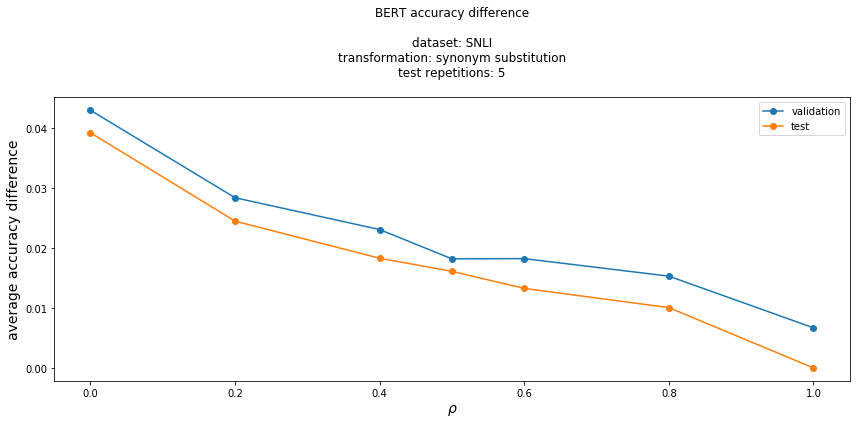

In [6]:
rhos, diff, _,_ = get_rho_stats_from_result_list(all_dev_plus_diff)
_, test_acc, _,_ = get_rho_stats_from_result_list(all_accs)
_, test_acc_t, _,_ = get_rho_stats_from_result_list(all_transformed_accs)
test_diff = np.abs(test_acc - test_acc_t)

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(rhos, diff, fmt='-o', label="validation");
ax.errorbar(rhos, test_diff, fmt='-o', label="test");

ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("average accuracy difference", fontsize=14);
ax.set_title("BERT accuracy difference\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
fig.tight_layout()
fig.savefig('figs/bert_acc_diff_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## Selecting the best $\rho$

In [7]:
id_min = np.argmin(diff)
min_rho = rhos[id_min]
min_rho_test_acc = test_acc[id_min]
min_rho_transformed_test_acc = test_acc_t[id_min]
test_accuracy_loss_pct = np.round(((min_rho_test_acc  - test_acc[0]) / test_acc[0]) * 100, 1)

analysis = {"dataset":"snli",
            "model": "BERT",
            "rho":min_rho,
            "test_accuracy_loss_pct": test_accuracy_loss_pct,
            "average_test_accuracy": min_rho_test_acc,
            "average_transformed_test_accuracy": min_rho_transformed_test_acc,
            "combined_accuracy": np.mean([min_rho_test_acc,min_rho_transformed_test_acc])}
analysis = pd.DataFrame(analysis, index=[0])
analysis

,dataset,model,rho,test_accuracy_loss_pct,average_test_accuracy,average_transformed_test_accuracy,combined_accuracy
0,snli,BERT,1.0,-1.0,0.847985,0.847903,0.847944
